<a href="https://colab.research.google.com/github/TEhyeok/AIFFEL_Exploration/blob/main/News_Summary_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-1. 프로젝트: 뉴스기사 요약해보기

In [2]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import summa
import pandas as pd

print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))

3.8.1
2.14.0
1.5.3
1.2.0


In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
67501,Cop arrested for attempting to rape 6-year-old...,A policeman in Uttar Pradesh has been arrested...
27694,Railways to replace face towels with napkins i...,The Railways has announced that it will replac...
90954,Two soldiers martyred in ceasefire violation i...,At least two soldiers were martyred in a cease...
55416,UK to switch from burgundy to blue passports a...,The UK will switch from burgundy to blue colou...
55435,Vandals damage 115 mn-year-old dinosaur footpr...,A three-toed dinosaur footprint dating back 11...
97936,"Pujara's ton takes India to 360/6, trail Aus b...",India ended day three of the Ranchi Test at 36...
56718,Maldives gets 1st ice skating rink next to the...,The Jumeirah Vittaveli hotel is opening Maldiv...
80170,"Wipro shares rise 5.5%, biggest intraday gain ...",Shares of India's third largest IT company Wip...
25616,No harm in health warning on cigarette packs: ...,The Supreme Court has refused to stay the new ...
5884,B'desh to build memorial for Indian soldiers k...,The Bangladesh government will be building a w...


In [6]:
# 전체 샘플 수
print(len(data))

98401


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [7]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for index, item in data.iterrows():
    text = preprocess_sentence(item['text'])

    clean_text.append(text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for index, item in data.iterrows():
    summary = preprocess_sentence(item['headlines'], False)

    clean_summary.append(summary)

print("headlines 전처리 후 결과: ", clean_summary[:5])

<ipython-input-10-1466dbc68293>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299651426306644


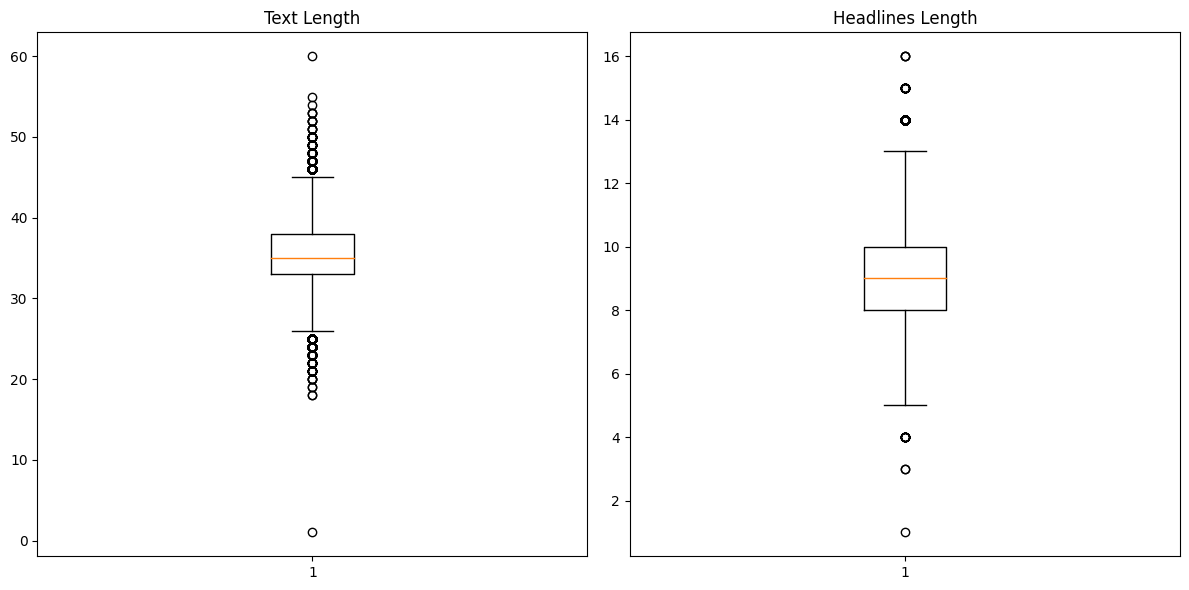

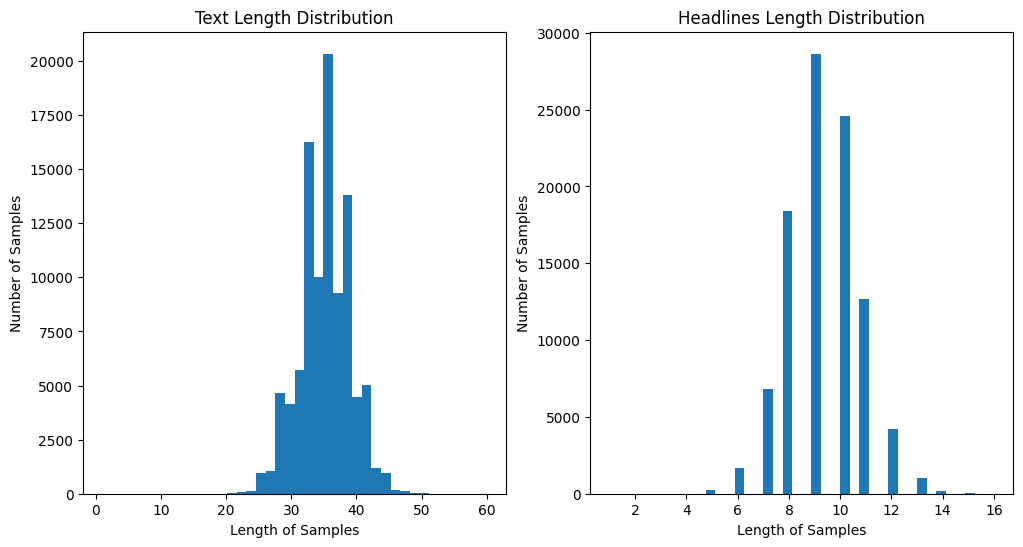

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 텍스트와 헤드라인의 길이 계산
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]  # 'Summary' 대신 'Headlines' 사용

# 기본 통계 정보 출력
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 박스 플롯으로 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text Length')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines Length')
plt.tight_layout()
plt.show()

# 히스토그램으로 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.hist(text_len, bins = 40)
plt.title('Text Length Distribution')
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')

plt.subplot(1,2,2)
plt.hist(headlines_len, bins = 40)
plt.title('Headlines Length Distribution')
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

# 전처리 전
# 텍스트의 최소 길이 : 1
# 텍스트의 최대 길이 : 91
# 텍스트의 평균 길이 : 58.2385341612382
# 헤드라인의 최소 길이 : 1
# 헤드라인의 최대 길이 : 18
# 헤드라인의 평균 길이 : 9.553906972490116

# 전처리 후
# 텍스트의 최소 길이 : 1
# 텍스트의 최대 길이 : 60
# 텍스트의 평균 길이 : 35.09983638377659
# 헤드라인의 최소 길이 : 1
# 헤드라인의 최대 길이 : 16
# 헤드라인의 평균 길이 : 9.299651426306644

In [17]:
text_max_len = 40
headlines_max_len = 10
print('=3')

=3


In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238320748772878
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162823548541174


In [20]:
# 길이 조건을 만족하는 샘플만 필터링
filtered_data = data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len, axis=1)
data = data[filtered_data]

# 결과 확인
print('전체 샘플수 :', len(data))

# 전체 샘플수 : 74128

전체 샘플수 : 74128


In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-21-5f0b0a3a6e34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-21-5f0b0a3a6e34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[58826 64982 34136 ...   639 43600 43427]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14825


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59303
훈련 레이블의 개수 : 59303
테스트 데이터의 개수 : 14825
테스트 레이블의 개수 : 14825


In [27]:
decoder_input_test[:3]

array(['sostoken insect eyes inspire new solar cell design',
       'sostoken nasa announces landing site for its mars rover',
       'sostoken after cancelling flights ryanair cancels more'],
      dtype=object)

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61569
등장 빈도가 6번 이하인 희귀 단어의 수: 42218
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19351
단어 집합에서 희귀 단어의 비율: 68.57022202731893
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.183453633835894


In [30]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[304, 9, 56, 1501, 420, 655, 50, 14, 2161, 1792, 6766, 679, 2475, 1378, 20, 9768, 5745, 2257, 581, 14, 7804, 179, 1, 680, 1018, 9041, 5985, 126, 276, 1196, 50, 14, 4673, 4011, 360], [8659, 327, 1423, 883, 4850, 5986, 3362, 210, 2485, 1534, 11317, 692, 611, 1324, 8659, 6439, 327, 752, 2598, 948, 2, 238, 18005, 2635, 314, 327, 7805, 5986, 270, 10957, 15913, 5040], [11, 104, 240, 18006, 2056, 73, 53, 91, 1735, 7, 27, 2056, 240, 1135, 2191, 147, 11717, 1157, 2606, 10304, 5825, 773, 10030, 8660, 7, 1003, 11, 34, 58, 4276, 10304, 5825, 1570, 3035]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27329
등장 빈도가 5번 이하인 희귀 단어의 수: 18235
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9094
단어 집합에서 희귀 단어의 비율: 66.72399282813129
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.959584349100092


In [34]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 207, 1039, 845, 2963, 5, 3117, 5397], [1, 37, 391, 8223, 3, 3839, 1535, 796, 2340], [1, 2650, 52, 5732, 5398, 4304, 11, 236, 567, 60], [1, 4879, 1882, 3118, 6, 223, 7537], [1, 919, 8, 486, 1008, 164, 87, 971, 1381, 3, 1515]]
target
decoder  [[207, 1039, 845, 2963, 5, 3117, 5397, 2], [37, 391, 8223, 3, 3839, 1535, 796, 2340, 2], [2650, 52, 5732, 5398, 4304, 11, 236, 567, 60, 2], [4879, 1882, 3118, 6, 223, 7537, 2], [919, 8, 486, 1008, 164, 87, 971, 1381, 3, 1515, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59303
훈련 레이블의 개수 : 59303
테스트 데이터의 개수 : 14825
테스트 레이블의 개수 : 14825


In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2560000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 39s 108ms/step - loss: 6.5737 - val_loss: 6.2287
Epoch 2/50
232/232 [==============================] - 20s 85ms/step - loss: 6.2260 - val_loss: 6.1424
Epoch 3/50
232/232 [==============================] - 19s 83ms/step - loss: 6.1779 - val_loss: 6.1170
Epoch 4/50
232/232 [==============================] - 20s 86ms/step - loss: 6.1122 - val_loss: 6.0318
Epoch 5/50
232/232 [==============================] - 19s 84ms/step - loss: 6.0420 - val_loss: 5.9886
Epoch 6/50
232/232 [==============================] - 20s 86ms/step - loss: 5.9784 - val_loss: 5.9243
Epoch 7/50
232/232 [==============================] - 20s 87ms/step - loss: 5.8581 - val_loss: 5.7832
Epoch 8/50
232/232 [==============================] - 21s 89ms/step - loss: 5.7469 - val_loss: 5.6944
Epoch 9/50
232/232 [==============================] - 20s 88ms/step - loss: 5.6595 - val_loss: 5.6184
Epoch 10/50
232/232 [==============================] - 20s 88ms/step - loss: 5.56

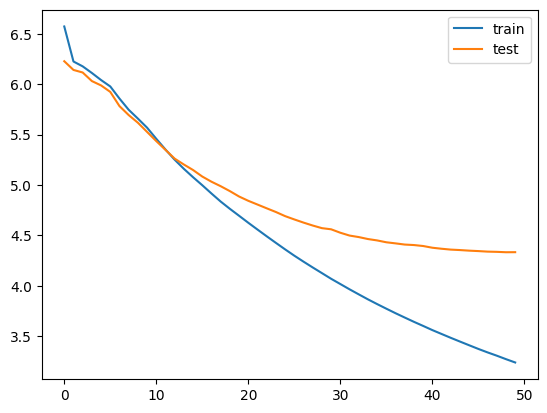

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')


=3


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [54]:
tar_word_to_index['eostoken']

2

In [55]:
decoder_input_test[:3]

array([[   1, 7072, 3249,   37,  874, 3222, 2167,    0,    0,    0],
       [   1,  272,  310, 1232,  982,    5,   67,  944, 4299,    0],
       [   1,   10, 6058,  960, 5776, 1072,  122,    0,    0,    0]],
      dtype=int32)

In [56]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old boy allegedly committed suicide gujarat tuesday lost newly purchased mobile phone deceased bought mobile phone worth around earnings feared parents would losing police official said meanwhile police looking possibilities behind suicide 
실제 요약 : year old gujarat boy hangs himself after losing new phone 
1/1 [==============================] - 0s 20ms/step
예측 요약 :  year old girl killed in gurugram for driving


원문 : according recently published us based research chance earth avoid warming least threshold set paris climate agreement research studied global trends economy emissions population growth stated chance temperatures rise less 
실제 요약 : only chance of earth reaching paris climate goal study 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  why are the most of the moon study


원문 : jammu kashmir governor satya pal malik said talked ipl chairman rajeev shukla forming ipl team state plan ipl team plans cricket football team focusing ipl team malik said plan 
실

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [57]:
!pip install summa

In [58]:
import pandas as pd
import urllib.request
from summa.summarizer import summarize

In [60]:
# 데이터셋 다운로드 및 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [61]:
# Summa를 사용하여 추출적 요약 수행 (첫 10개의 샘플에 대해)
for i in range(10):
    print(f"기사 {i+1} 요약:")
    print("원본 Headline:", data1['headlines'][i])
    print("추출적 요약:", summarize(data1['text'][i], ratio=0.5))
    print("\n")

기사 1 요약:
원본 Headline: upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


기사 2 요약:
원본 Headline: Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


기사 3 요약:
원본 Headline: New Zealand end Rohit Sharma-led India's 12-match winning streak
추출적 요약: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


기사 4 요약:
원본 Headline: Aegon life iTerm insurance plan helps customers save tax
추출적 요약: Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


기사 5 요약:
원본 Headline: Have known Hirani for yrs, what if MeToo claims are not true: Sonam
추출적 요약: Speaking about the sexual harassment allegations against R

In [64]:
comparison_df = pd.DataFrame(columns=["원문", "실제 요약", "추상적 요약", "추출적 요약"])

# 추상적 요약과 추출적 요약 결과 비교
for i in range(10):
    # 원문
    original_text = seq2text(encoder_input_test[i])

    # 실제 요약
    actual_summary = seq2summary(decoder_input_test[i])

    # 추상적 요약
    abstract_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

    # 추출적 요약
    extractive_summary = summarize(data1['text'][i], ratio=0.5)

    # 결과를 데이터 프레임에 추가
    comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,
                                          "추상적 요약": abstract_summary, "추출적 요약": extractive_summary},
                                         ignore_index=True)

# 결과 표시
print(comparison_df)


1/1 [==============================] - 0s 19ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 20ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 22ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 21ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 20ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 21ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 21ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 21ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 22ms/step


<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,


1/1 [==============================] - 0s 22ms/step
                                                  원문  \
0  inspired compound eye fly stanford researchers...   
1  nasa announced billion year old crater called ...   
2  announced cancellation flights till october ry...   
3  woman chhattisgarh forced give birth autoricks...   
4  uber agreed pay million settlement data breach...   
5  crpf jawan killed four troopers camp chhattisg...   
6  claiming supreme court misled government congr...   
7  book career manipur singh known personal strug...   
8  delhi national zoological park wednesday launc...   
9  south korean technology company samsung report...   

                                               실제 요약  \
0                 insect eyes new solar cell design    
1    nasa announces landing site for its mars rover    
2     after cancelling flights ryanair cancels more    
3  woman gives birth in auto as no doctors were a...   
4  uber to pay million in settlement over data br..

<ipython-input-64-d6008d062562>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({"원문": original_text, "실제 요약": actual_summary,
